In [245]:
#Laos Small Group Project

#This python script models the Laotian power network in 2050 following the Net-Zero Scenario data proposed by the team. The domestic network
#is simplified into 4 regions (North, Central 1, Central 2, South), and generation is distributed along them according to previously identified
#renewable energy potential and land constraints.

#Domestic demand in 2050 is distributed across the 4 regions proportionally to population
#Export demand is based on export commitments to Thailand, Vietnam, China, Myanmar, and Cambodia and following existing infrastructures

#Local voltage levels are at 115kV, while exports to Vietnam and Thailand are at 230kV, with 3 transformers used to upgrade voltage levels

#All input parameters are available in the excel sheet "laos Python Model Inputs" also available in the same GitHub folder

In [1]:
# Import libraries
import pandas as pd
import pandapower as pp
from pandapower.plotting.plotly import simple_plotly


In [2]:
import numpy as np

In [3]:
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import seaborn

In [15]:
#df_loop = pd.DataFrame(columns=["dispatch_percentage", "max_loading", "min_loading"])
#df_loop.loc[0] = [1,2,3]
#print(df_loop)

#for i in np.arange(100,45,-5):
#    print(i)

In [43]:
#create loop

df_loop = pd.DataFrame(columns=["dispatch_percentage", "max_loading"])
print(df_loop)

count = 0

for dispatch_perc in range(100,50,-5):
    # Create network
    net = pp.create_empty_network() 
    #Read bus data from excel
    bus_df=pd.read_excel(r"bolivia python input.xlsx", sheet_name='buses',nrows=15)
    #bus_df
    # Create buses
    b = {}

    for i in bus_df['bus_id']:
        b[i] = pp.create_bus(net, vn_kv = bus_df.loc[bus_df['bus_id']==i, 'vn_kv'].values[0], name = bus_df.loc[bus_df['bus_id']==i, 'name'].values[0], geodata = eval(bus_df.loc[bus_df['bus_id']==i, 'geodata'].values[0]),min_vm_pu=0.85)
    net.bus

    # Create one grid connection point
    connect_bus = b[0] 
    vm_pu = 1.1

    # Create the external grid connection
    pp.create_ext_grid(net, bus=connect_bus, vm_pu=vm_pu, name = "Slack bus")

    # Import line data from excel file-- from_bus, to_bus, length_km, r_ohm_per_km, x_ohm_per_km, c_nf_per_km, max_i_ka

    line_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='lines',nrows=12)
    #line_df

    # Create lines
    for i in line_df.index:
        pp.create_line_from_parameters(net, from_bus=b[line_df.loc[i, 'from_bus']],
                                    to_bus=b[line_df.loc[i, 'to_bus']],
                                    length_km=line_df.loc[i, 'length_km'],
                                    r_ohm_per_km=line_df.loc[i, 'r_ohm_per_km'],
                                    x_ohm_per_km=line_df.loc[i, 'x_ohm_per_km'],
                                    c_nf_per_km=line_df.loc[i, 'c_nf_per_km'],
                                    max_i_ka=line_df.loc[i, 'max_i_ka']
                                    ) 
    net.line

    # Import Load data from excel-- geolocation, bus (nearest from geolocation), p_mw
    load_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='loads',nrows=9)
    #load_df

    # Create loads
    p_mw = 'power_p_mw'
    q_mvar = 'power_q_mvar'

    for i in load_df['bus_id']:
        pp.create_load(net, 
                    b[i], 
                    p_mw=load_df.loc[load_df['bus_id']==i, p_mw].values[0], 
                    q_mvar=load_df.loc[load_df['bus_id']==i, q_mvar].values[0],
                    name=load_df.loc[load_df['bus_id']==i, 'name'].values[0])
    
    net.bus

    # Generators imported from excel
    vm_pu=1.1

#### make the excel sheets in this style "gen 100"  "gen 95" etc. down from 100 to 50 in steps of 5
    gen_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='gen',nrows=9)
    print("sheet_name: ", 'gen ' + str(dispatch_perc))
    #gen_df  

    #Generators
    for i in gen_df['gen_id']:
        pp.create_gen(net, bus=gen_df.loc[gen_df['gen_id']==i, 'bus_id'].values[0],
                    p_mw=gen_df.loc[gen_df['gen_id']==i, 'p_mw_' + str(dispatch_perc)].values[0],vm_pu=1, 
                    name=gen_df.loc[gen_df['gen_id']==i, 'name'].values[0])
    net.gen

    #USE THIS FOR TRANSFORMER
    # Define the voltage levels
    vk_percent = 12
    vkr_percent = 0.26
    pfe_kw = 3.2
    i0_percent = 0.06

    # Create the transformers where voltage changes
    pp.create_transformer_from_parameters(net, 0, 9, sn_mva=40, vn_hv_kv=230, vn_lv_kv=115, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
    pp.create_transformer_from_parameters(net, 10, 2, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
    pp.create_transformer_from_parameters(net, 3, 11, sn_mva=40, vn_hv_kv=230, vn_lv_kv=115, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
    pp.create_transformer_from_parameters(net, 6, 12, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
    pp.create_transformer_from_parameters(net, 13, 4, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
    pp.create_transformer_from_parameters(net, 14, 7, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)


    # Set the voltage setpoint of all generators at bus 0 to 1.0 p.u.
    net.gen.loc[net.gen.bus == 0, 'vm_pu'] = 1.0

    # Set the voltage setpoint of all external grids at bus 0 to 1.0 p.u.
    net.ext_grid.loc[net.ext_grid.bus == 0, 'vm_pu'] = 1.0

    # Set the voltage setpoint of all DC lines at bus 0 to 1.0 p.u.
    net.dcline.loc[net.dcline.from_bus == 0, 'vm_from_pu'] = 1.0
    net.dcline.loc[net.dcline.to_bus == 0, 'vm_to_pu'] = 1.0

    try:# Run the network using the NR algorithm
        pp.runpp(net, algorithm='nr', max_iteration=10000, numba=False);
    except: 
        print(str(dispatch_perc) + " did not work")
        continue

    net

    net.res_line


##### if there is a problem it is probably the following line
    max_loading = net.res_line["loading_percent"].max()

    # Display bus results
    #net.res_bus

    # Display generator results
    #net.res_gen

    #Display transformer results
    #net.res_trafo

    df_loop.loc[count] = [dispatch_perc,max_loading]
    count += 1

print(df_loop)
    

Empty DataFrame
Columns: [dispatch_percentage, max_loading]
Index: []
sheet_name:  gen 100
sheet_name:  gen 95
sheet_name:  gen 90
sheet_name:  gen 85
sheet_name:  gen 80
sheet_name:  gen 75
sheet_name:  gen 70
sheet_name:  gen 65
sheet_name:  gen 60
sheet_name:  gen 55
55 did not work
   dispatch_percentage  max_loading
0                100.0   468.755174
1                 95.0   468.024497
2                 90.0   491.055910
3                 85.0   133.356971
4                 80.0   105.240861
5                 75.0    80.208393
6                 70.0    56.205049
7                 65.0    65.030070
8                 60.0    85.955266


In [50]:
print(df_loop)

df_loop.to_csv("dispatchable_capacity_online_vs_max_loading_perc.csv", index=False)

   dispatch_percentage  max_loading
0                100.0   468.755174
1                 95.0   468.024497
2                 90.0   491.055910
3                 85.0   133.356971
4                 80.0   105.240861
5                 75.0    80.208393
6                 70.0    56.205049
7                 65.0    65.030070
8                 60.0    85.955266


use_bus_geodata is automatically set to True, since net.line_geodata is empty.


sheet_name:  gen 75


<Axes: >

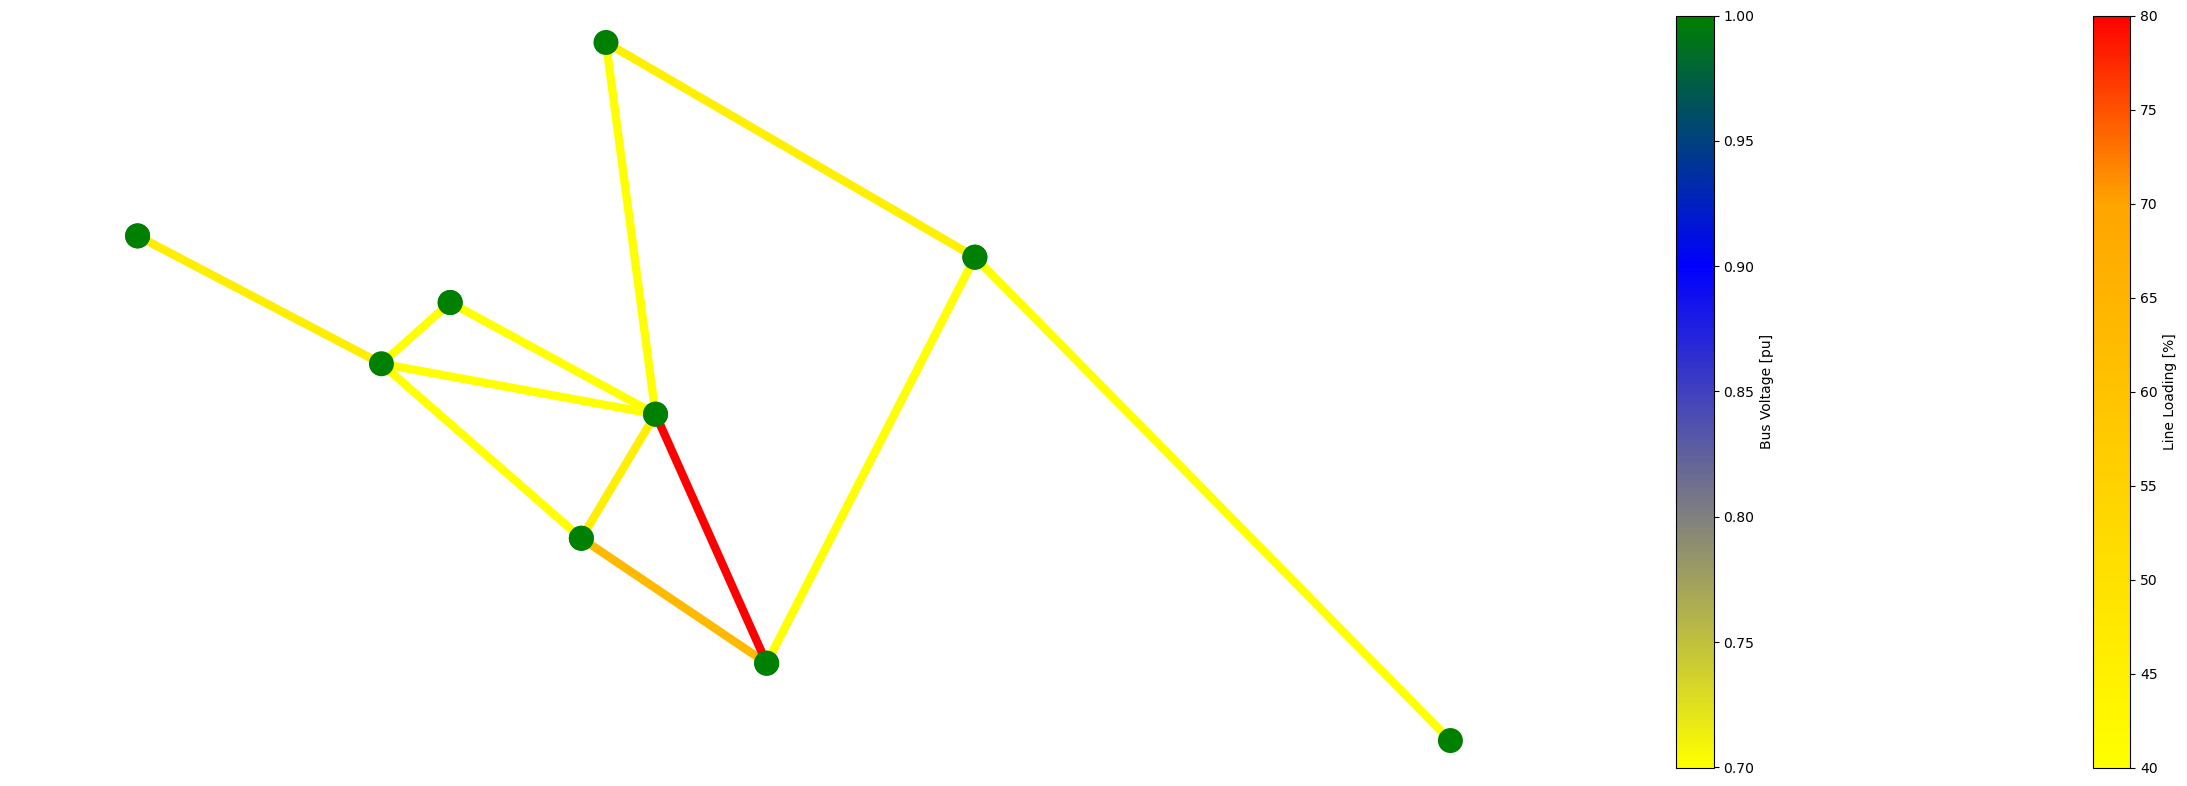

In [44]:
dispatch_perc = 75




# Create network
net = pp.create_empty_network() 
#Read bus data from excel
bus_df=pd.read_excel(r"bolivia python input.xlsx", sheet_name='buses',nrows=15)
#bus_df
# Create buses
b = {}

for i in bus_df['bus_id']:
    b[i] = pp.create_bus(net, vn_kv = bus_df.loc[bus_df['bus_id']==i, 'vn_kv'].values[0], name = bus_df.loc[bus_df['bus_id']==i, 'name'].values[0], geodata = eval(bus_df.loc[bus_df['bus_id']==i, 'geodata'].values[0]),min_vm_pu=0.85)
net.bus

# Create one grid connection point
connect_bus = b[0] 
vm_pu = 1.1

# Create the external grid connection
pp.create_ext_grid(net, bus=connect_bus, vm_pu=vm_pu, name = "Slack bus")

# Import line data from excel file-- from_bus, to_bus, length_km, r_ohm_per_km, x_ohm_per_km, c_nf_per_km, max_i_ka

line_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='lines',nrows=12)
#line_df

# Create lines
for i in line_df.index:
    pp.create_line_from_parameters(net, from_bus=b[line_df.loc[i, 'from_bus']],
                                to_bus=b[line_df.loc[i, 'to_bus']],
                                length_km=line_df.loc[i, 'length_km'],
                                r_ohm_per_km=line_df.loc[i, 'r_ohm_per_km'],
                                x_ohm_per_km=line_df.loc[i, 'x_ohm_per_km'],
                                c_nf_per_km=line_df.loc[i, 'c_nf_per_km'],
                                max_i_ka=line_df.loc[i, 'max_i_ka']
                                ) 
net.line

# Import Load data from excel-- geolocation, bus (nearest from geolocation), p_mw
load_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='loads',nrows=9)
#load_df

# Create loads
p_mw = 'power_p_mw'
q_mvar = 'power_q_mvar'

for i in load_df['bus_id']:
    pp.create_load(net, 
                b[i], 
                p_mw=load_df.loc[load_df['bus_id']==i, p_mw].values[0], 
                q_mvar=load_df.loc[load_df['bus_id']==i, q_mvar].values[0],
                name=load_df.loc[load_df['bus_id']==i, 'name'].values[0])

net.bus

# Generators imported from excel
vm_pu=1.1

#### make the excel sheets in this style "gen 100"  "gen 95" etc. down from 100 to 50 in steps of 5
gen_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='gen',nrows=9)
print("sheet_name: ", 'gen ' + str(dispatch_perc))
#gen_df  

#Generators
for i in gen_df['gen_id']:
    pp.create_gen(net, bus=gen_df.loc[gen_df['gen_id']==i, 'bus_id'].values[0],
                p_mw=gen_df.loc[gen_df['gen_id']==i, 'p_mw_' + str(dispatch_perc)].values[0],vm_pu=1, 
                name=gen_df.loc[gen_df['gen_id']==i, 'name'].values[0])
net.gen

#USE THIS FOR TRANSFORMER
# Define the voltage levels
vk_percent = 12
vkr_percent = 0.26
pfe_kw = 3.2
i0_percent = 0.06

# Create the transformers where voltage changes
pp.create_transformer_from_parameters(net, 0, 9, sn_mva=40, vn_hv_kv=230, vn_lv_kv=115, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 10, 2, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 3, 11, sn_mva=40, vn_hv_kv=230, vn_lv_kv=115, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 6, 12, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 13, 4, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 14, 7, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)


# Set the voltage setpoint of all generators at bus 0 to 1.0 p.u.
net.gen.loc[net.gen.bus == 0, 'vm_pu'] = 1.0

# Set the voltage setpoint of all external grids at bus 0 to 1.0 p.u.
net.ext_grid.loc[net.ext_grid.bus == 0, 'vm_pu'] = 1.0

# Set the voltage setpoint of all DC lines at bus 0 to 1.0 p.u.
net.dcline.loc[net.dcline.from_bus == 0, 'vm_from_pu'] = 1.0
net.dcline.loc[net.dcline.to_bus == 0, 'vm_to_pu'] = 1.0


pp.runpp(net, algorithm='nr', max_iteration=10000, numba=False);

net

net.res_line


##### if there is a problem it is probably the following line
#max_loading = net.res_line["loading_percent"].max()

# Display bus results
net.res_bus

# Display generator results
net.res_gen

#Display transformer results
net.res_trafo

#df_loop.loc[count] = [dispatch_perc,max_loading]
#count += 1


#Plotting

 # Plot an advanced visual of the network showing the line loading results and voltage drops

# Creating the line color collection
cmap_list=[(40, "yellow"), (70, "orange"), (80, "red")]
cmap, norm = plot.cmap_continuous(cmap_list)
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=6)

# Creating the bus color collection
cmap_list=[(0.7, "yellow"), (0.9, "blue"), (1.0, "green")]
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap, norm=norm)

plot.draw_collections([lc, bc], figsize=(25,8))

In [36]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,707.575918,-468.389952
1,1.000000,-69.790559,141.627688,-81.226219
2,1.000000,-25.840890,329.160881,-280.533473
3,1.000000,30.751169,-96.708038,-140.698639
4,1.000000,41.307140,-1293.019273,-122.043808
5,1.000000,15.928191,-64.984126,-167.384345
6,1.000000,33.668049,-78.267891,-73.555117
7,1.000000,38.491365,16.734410,-3.863582
8,1.000000,-18.801006,136.709227,-92.541075
9,0.999964,-0.000231,0.000000,0.000000


use_bus_geodata is automatically set to True, since net.line_geodata is empty.


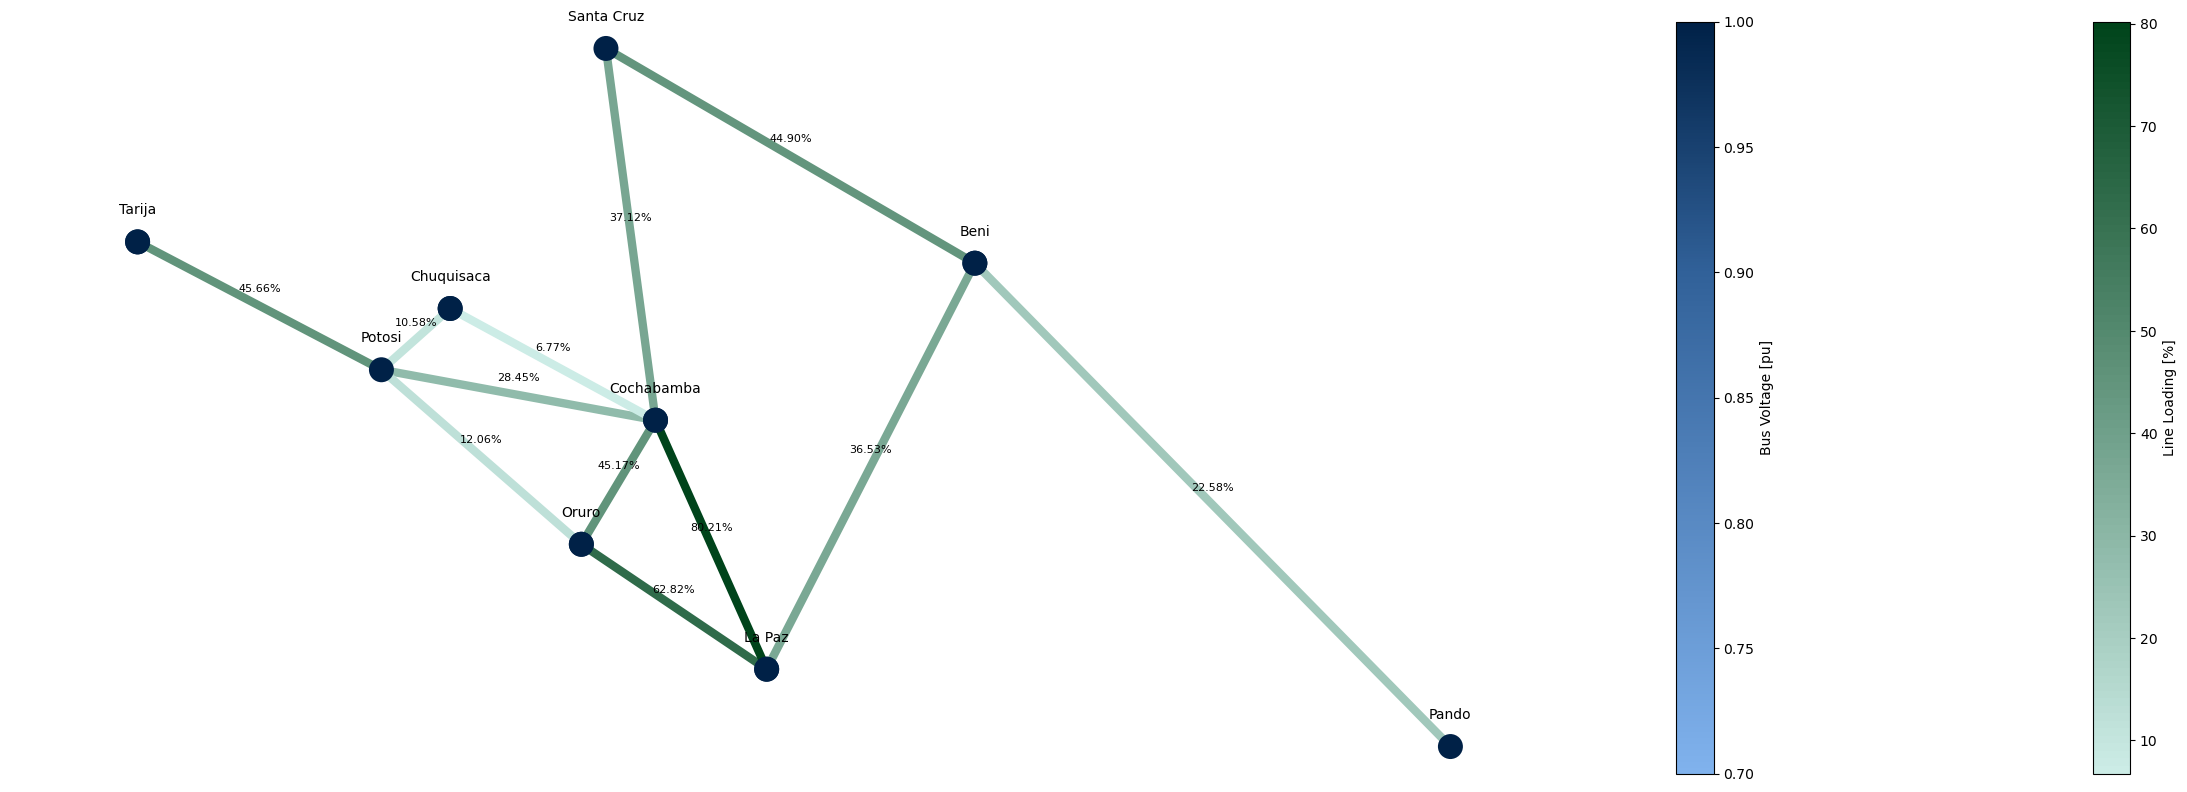

In [45]:
# Plot an advanced visual of the network showing the line loading results and voltage drops

import pandapower.plotting as plot
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import matplotlib as mpl

# Define the colors and number of bins for the custom colormap
colors = ["#ccece6", "#00441b"]
colors_2 = ["#fec44f", "#cc4c02"]
#colors_2 = ["#002147", "#002147"]
#002147
n_bins = 100  # Use 100 bins for the gradient
n_bins2 = 5

# Create a colormap object
cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)
cmap2 = mpl.colors.LinearSegmentedColormap.from_list("custom_colormap", colors_2, N=n_bins2)

# Creating the line color collection
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, linewidths=6)

# Creating the bus color collection
#bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap2)

# Creating the bus color collection
cmap_list=[(0.7, "#80b2ed"), (0.9, "#316199"), (1.0, "#002147")]
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap, norm=norm)

# Draw the collections
plot.draw_collections([lc, bc], figsize=(25,8))

# Calculate the loading percentage for each line
loading_percentages = net.res_line.loading_percent

# Get the midpoint of each line for the annotation
midpoints = np.array([((net.bus_geodata.loc[net.line.from_bus[i], 'x'] + net.bus_geodata.loc[net.line.to_bus[i], 'x']) / 2,
                       (net.bus_geodata.loc[net.line.from_bus[i], 'y'] + net.bus_geodata.loc[net.line.to_bus[i], 'y']) / 2)
                      for i in net.line.index])

# Annotate the plot with the loading percentages
for i, (x, y) in enumerate(midpoints):
    plt.annotate(f'{loading_percentages[i]:.2f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Annotate the plot with the bus names, excluding buses 9, 10, 11, 12, 13, and 14
excluded_buses = [9, 10, 11, 12, 13, 14]
for i in net.bus.index:
    if i not in excluded_buses:
        plt.annotate(net.bus.name.at[i], (net.bus_geodata.x.at[i], net.bus_geodata.y.at[i]), textcoords="offset points", xytext=(0,20), ha='center', fontsize=10)

# Show the plot
plt.show()

use_bus_geodata is automatically set to True, since net.line_geodata is empty.


sheet_name:  gen 60


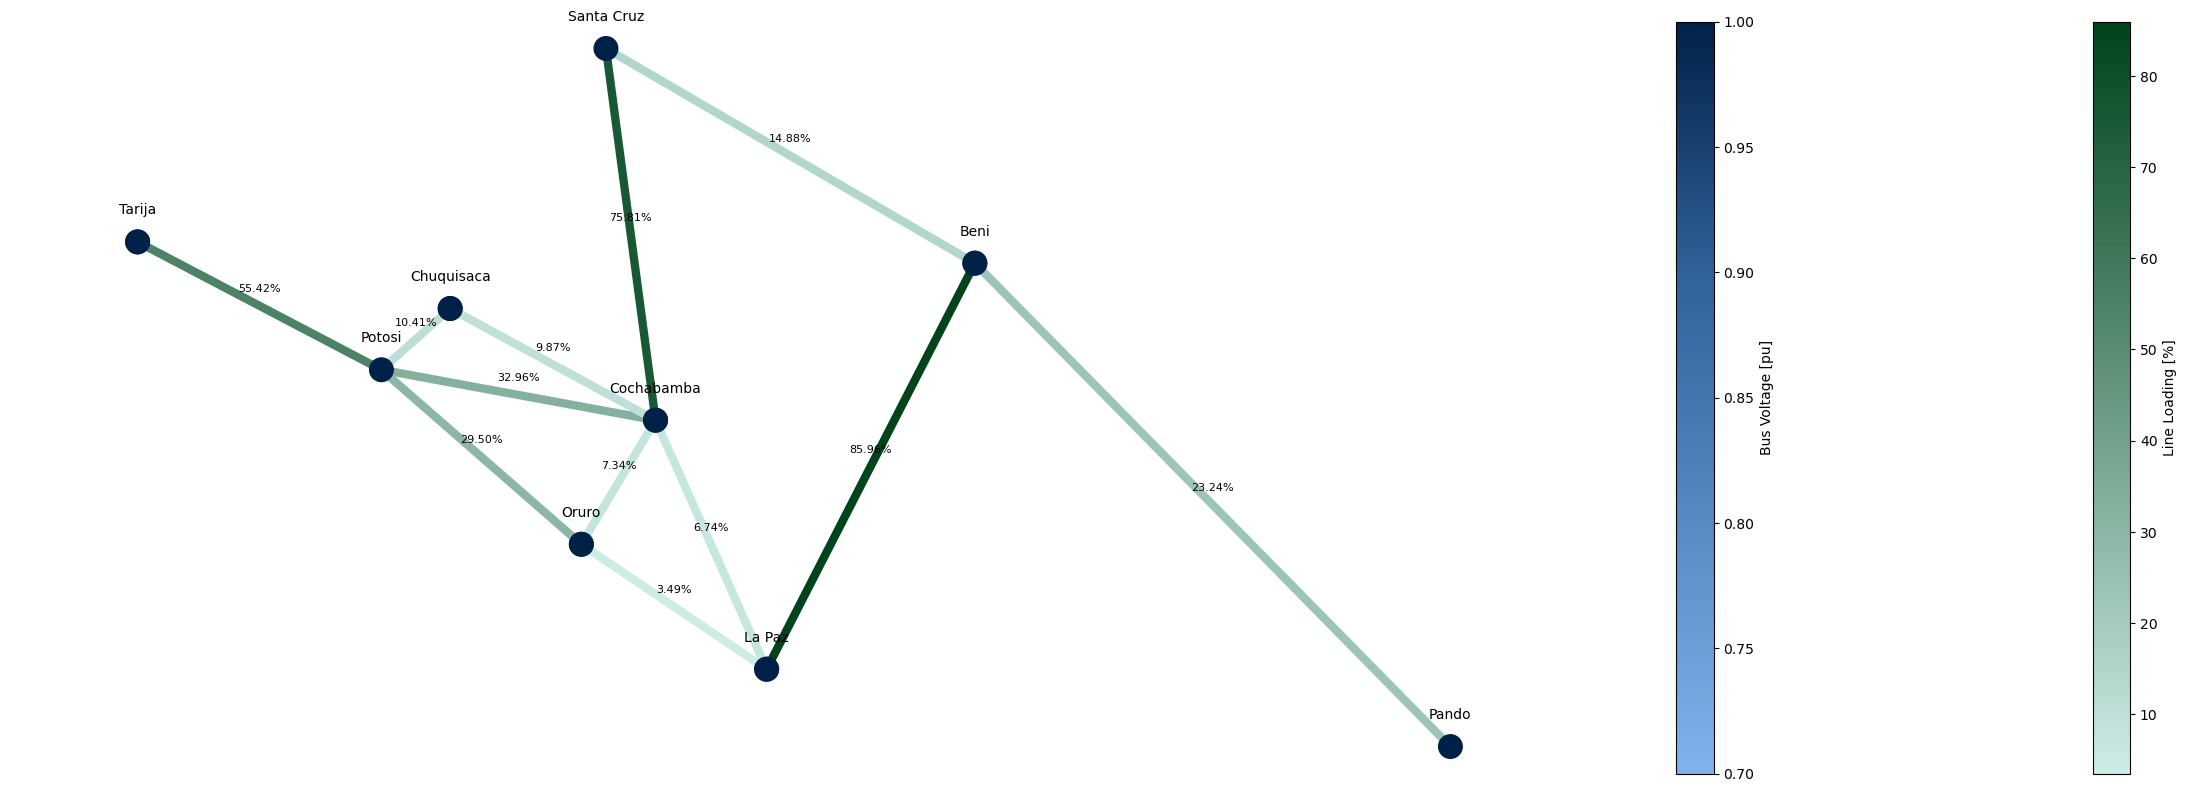

In [46]:
# 60% load flow 


dispatch_perc = 60




# Create network
net = pp.create_empty_network() 
#Read bus data from excel
bus_df=pd.read_excel(r"bolivia python input.xlsx", sheet_name='buses',nrows=15)
#bus_df
# Create buses
b = {}

for i in bus_df['bus_id']:
    b[i] = pp.create_bus(net, vn_kv = bus_df.loc[bus_df['bus_id']==i, 'vn_kv'].values[0], name = bus_df.loc[bus_df['bus_id']==i, 'name'].values[0], geodata = eval(bus_df.loc[bus_df['bus_id']==i, 'geodata'].values[0]),min_vm_pu=0.85)
net.bus

# Create one grid connection point
connect_bus = b[0] 
vm_pu = 1.1

# Create the external grid connection
pp.create_ext_grid(net, bus=connect_bus, vm_pu=vm_pu, name = "Slack bus")

# Import line data from excel file-- from_bus, to_bus, length_km, r_ohm_per_km, x_ohm_per_km, c_nf_per_km, max_i_ka

line_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='lines',nrows=12)
#line_df

# Create lines
for i in line_df.index:
    pp.create_line_from_parameters(net, from_bus=b[line_df.loc[i, 'from_bus']],
                                to_bus=b[line_df.loc[i, 'to_bus']],
                                length_km=line_df.loc[i, 'length_km'],
                                r_ohm_per_km=line_df.loc[i, 'r_ohm_per_km'],
                                x_ohm_per_km=line_df.loc[i, 'x_ohm_per_km'],
                                c_nf_per_km=line_df.loc[i, 'c_nf_per_km'],
                                max_i_ka=line_df.loc[i, 'max_i_ka']
                                ) 
net.line

# Import Load data from excel-- geolocation, bus (nearest from geolocation), p_mw
load_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='loads',nrows=9)
#load_df

# Create loads
p_mw = 'power_p_mw'
q_mvar = 'power_q_mvar'

for i in load_df['bus_id']:
    pp.create_load(net, 
                b[i], 
                p_mw=load_df.loc[load_df['bus_id']==i, p_mw].values[0], 
                q_mvar=load_df.loc[load_df['bus_id']==i, q_mvar].values[0],
                name=load_df.loc[load_df['bus_id']==i, 'name'].values[0])

net.bus

# Generators imported from excel
vm_pu=1.1

#### make the excel sheets in this style "gen 100"  "gen 95" etc. down from 100 to 50 in steps of 5
gen_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='gen',nrows=9)
print("sheet_name: ", 'gen ' + str(dispatch_perc))
#gen_df  

#Generators
for i in gen_df['gen_id']:
    pp.create_gen(net, bus=gen_df.loc[gen_df['gen_id']==i, 'bus_id'].values[0],
                p_mw=gen_df.loc[gen_df['gen_id']==i, 'p_mw_' + str(dispatch_perc)].values[0],vm_pu=1, 
                name=gen_df.loc[gen_df['gen_id']==i, 'name'].values[0])
net.gen

#USE THIS FOR TRANSFORMER
# Define the voltage levels
vk_percent = 12
vkr_percent = 0.26
pfe_kw = 3.2
i0_percent = 0.06

# Create the transformers where voltage changes
pp.create_transformer_from_parameters(net, 0, 9, sn_mva=40, vn_hv_kv=230, vn_lv_kv=115, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 10, 2, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 3, 11, sn_mva=40, vn_hv_kv=230, vn_lv_kv=115, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 6, 12, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 13, 4, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 14, 7, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)


# Set the voltage setpoint of all generators at bus 0 to 1.0 p.u.
net.gen.loc[net.gen.bus == 0, 'vm_pu'] = 1.0

# Set the voltage setpoint of all external grids at bus 0 to 1.0 p.u.
net.ext_grid.loc[net.ext_grid.bus == 0, 'vm_pu'] = 1.0

# Set the voltage setpoint of all DC lines at bus 0 to 1.0 p.u.
net.dcline.loc[net.dcline.from_bus == 0, 'vm_from_pu'] = 1.0
net.dcline.loc[net.dcline.to_bus == 0, 'vm_to_pu'] = 1.0


pp.runpp(net, algorithm='nr', max_iteration=10000, numba=False);

net

net.res_line


##### if there is a problem it is probably the following line
#max_loading = net.res_line["loading_percent"].max()

# Display bus results
net.res_bus

# Display generator results
net.res_gen

#Display transformer results
net.res_trafo

#df_loop.loc[count] = [dispatch_perc,max_loading]
#count += 1




# Plot an advanced visual of the network showing the line loading results and voltage drops

import pandapower.plotting as plot
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import matplotlib as mpl

# Define the colors and number of bins for the custom colormap
colors = ["#ccece6", "#00441b"]
colors_2 = ["#fec44f", "#cc4c02"]
#colors_2 = ["#002147", "#002147"]
#002147
n_bins = 100  # Use 100 bins for the gradient

# Create a colormap object
cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)
cmap2 = mpl.colors.LinearSegmentedColormap.from_list("custom_colormap", colors_2, N=n_bins)

# Creating the line color collection
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, linewidths=6)

# Creating the bus color collection
#bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap2)

# Creating the bus color collection
cmap_list=[(0.7, "#80b2ed"), (0.9, "#316199"), (1.0, "#002147")]
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap, norm=norm)

# Draw the collections
plot.draw_collections([lc, bc], figsize=(25,8))

# Calculate the loading percentage for each line
loading_percentages = net.res_line.loading_percent

# Get the midpoint of each line for the annotation
midpoints = np.array([((net.bus_geodata.loc[net.line.from_bus[i], 'x'] + net.bus_geodata.loc[net.line.to_bus[i], 'x']) / 2,
                       (net.bus_geodata.loc[net.line.from_bus[i], 'y'] + net.bus_geodata.loc[net.line.to_bus[i], 'y']) / 2)
                      for i in net.line.index])

# Annotate the plot with the loading percentages
for i, (x, y) in enumerate(midpoints):
    plt.annotate(f'{loading_percentages[i]:.2f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Annotate the plot with the bus names, excluding buses 9, 10, 11, 12, 13, and 14
excluded_buses = [9, 10, 11, 12, 13, 14]
for i in net.bus.index:
    if i not in excluded_buses:
        plt.annotate(net.bus.name.at[i], (net.bus_geodata.x.at[i], net.bus_geodata.y.at[i]), textcoords="offset points", xytext=(0,20), ha='center', fontsize=10)

# Show the plot
plt.show()

In [8]:
import matplotlib.pyplot as plt

In [9]:
import mpl_plotter as mpl

ModuleNotFoundError: No module named 'mpl_plotter'

In [14]:
#Plotting

 # Plot an advanced visual of the network showing the line loading results and voltage drops

#colors = ["#CCCCCC", "#002147"]
#n_bins = 100  # Use 100 bins for the gradient
 
# Create a colormap object
#cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)

# Creating the line color collection
cmap_list=[(40, "#002147"), (80, "#002147")]
cmap, norm = plot.cmap_continuous(cmap_list)
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=6)

# Creating the bus color collection
cmap_list=[(0.7, "#002147"), (1.0, "#002147")]
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap, norm=norm)

plot.draw_collections([lc, bc], figsize=(25,8))

ValueError: '#002147' is not a valid color value.

In [12]:
df_new_lines = df_loop.copy()
print(df_new_lines)

   dispatch_percentage  max_loading
0                100.0   468.755174
1                 95.0   468.024497
2                 90.0   491.055910
3                 85.0   133.356971
4                 80.0   105.240861
5                 75.0    80.208393
6                 70.0    56.205049
7                 65.0    65.030070
8                 60.0    85.955266


In [247]:
# Create network
net = pp.create_empty_network() 


In [248]:
#Read bus data from excel
bus_df=pd.read_excel(r"C:\Users\User\Downloads\bolivia python input.xlsx", sheet_name='buses',nrows=15)
#bus_df

In [249]:
# Create buses
b = {}

for i in bus_df['bus_id']:
  b[i] = pp.create_bus(net, vn_kv = bus_df.loc[bus_df['bus_id']==i, 'vn_kv'].values[0], name = bus_df.loc[bus_df['bus_id']==i, 'name'].values[0], geodata = eval(bus_df.loc[bus_df['bus_id']==i, 'geodata'].values[0]),min_vm_pu=0.85)
net.bus

,name,vn_kv,type,zone,in_service,min_vm_pu
0,La Paz,230.0,b,None,True,0.85
1,Pando,230.0,b,None,True,0.85
2,Beni,230.0,b,None,True,0.85
3,Oruro,230.0,b,None,True,0.85
4,Cochabamba,230.0,b,None,True,0.85
5,Santa Cruz,230.0,b,None,True,0.85
6,Potosi,115.0,b,None,True,0.85
7,Chuquisaca,230.0,b,None,True,0.85
8,Tarija,230.0,b,None,True,0.85
9,trafo02,115.0,b,None,True,0.85


In [250]:
# Create one grid connection point
connect_bus = b[0] 
vm_pu = 1.1

# Create the external grid connection
pp.create_ext_grid(net, bus=connect_bus, vm_pu=vm_pu, name = "Slack bus")

0

In [251]:
# Import line data from excel file-- from_bus, to_bus, length_km, r_ohm_per_km, x_ohm_per_km, c_nf_per_km, max_i_ka

line_df = pd.read_excel(r"C:\Users\User\Downloads\bolivia python input.xlsx", sheet_name='lines',nrows=12)
#line_df

In [252]:
# Create lines
for i in line_df.index:
  pp.create_line_from_parameters(net, from_bus=b[line_df.loc[i, 'from_bus']],
                                 to_bus=b[line_df.loc[i, 'to_bus']],
                                 length_km=line_df.loc[i, 'length_km'],
                                 r_ohm_per_km=line_df.loc[i, 'r_ohm_per_km'],
                                 x_ohm_per_km=line_df.loc[i, 'x_ohm_per_km'],
                                 c_nf_per_km=line_df.loc[i, 'c_nf_per_km'],
                                 max_i_ka=line_df.loc[i, 'max_i_ka']
                                 ) 
net.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,None,None,2,0,477.0,0.03806,0.222438,0.000008,0.0,1.510,1.0,1,None,True
1,None,None,0,3,286.0,0.02953,0.213900,0.000008,0.0,1.815,1.0,1,None,True
2,None,None,0,4,298.0,0.02953,0.213900,0.000008,0.0,1.815,1.0,1,None,True
3,None,None,3,4,138.0,0.02953,0.213900,0.000008,0.0,1.815,1.0,1,None,True
4,None,None,4,5,401.0,0.02953,0.213900,0.000008,0.0,1.815,1.0,1,None,True
5,None,None,5,2,538.0,0.02953,0.213900,0.000008,0.0,1.815,1.0,1,None,True
6,None,None,4,6,365.0,0.03806,0.222438,0.000008,0.0,1.510,1.0,1,None,True
7,None,None,3,6,329.0,0.03806,0.222438,0.000008,0.0,1.510,1.0,1,None,True
8,None,None,6,7,155.0,0.03806,0.222438,0.000008,0.0,1.510,1.0,1,None,True
9,None,None,4,7,246.0,0.02953,0.213900,0.000008,0.0,1.815,1.0,1,None,True


In [253]:
# Import Load data from excel-- geolocation, bus (nearest from geolocation), p_mw
load_df = pd.read_excel(r"C:\Users\User\Downloads\bolivia python input.xlsx", sheet_name='loads',nrows=9)
#load_df

In [254]:
# Create loads
p_mw = 'power_p_mw'
q_mvar = 'power_q_mvar'

for i in load_df['bus_id']:
  pp.create_load(net, 
                 b[i], 
                 p_mw=load_df.loc[load_df['bus_id']==i, p_mw].values[0], 
                 q_mvar=load_df.loc[load_df['bus_id']==i, q_mvar].values[0],
                 name=load_df.loc[load_df['bus_id']==i, 'name'].values[0])

In [255]:
net.bus

,name,vn_kv,type,zone,in_service,min_vm_pu
0,La Paz,230.0,b,None,True,0.85
1,Pando,230.0,b,None,True,0.85
2,Beni,230.0,b,None,True,0.85
3,Oruro,230.0,b,None,True,0.85
4,Cochabamba,230.0,b,None,True,0.85
5,Santa Cruz,230.0,b,None,True,0.85
6,Potosi,115.0,b,None,True,0.85
7,Chuquisaca,230.0,b,None,True,0.85
8,Tarija,230.0,b,None,True,0.85
9,trafo02,115.0,b,None,True,0.85


In [256]:
# Generators imported from excel
vm_pu=1.1

gen_df = pd.read_excel(r"C:\Users\User\Downloads\bolivia python input.xlsx", sheet_name='gen',nrows=9)
#gen_df    

In [257]:
#Generators
for i in gen_df['gen_id']:
  pp.create_gen(net, bus=gen_df.loc[gen_df['gen_id']==i, 'bus_id'].values[0],
                 p_mw=gen_df.loc[gen_df['gen_id']==i, 'p_mw'].values[0],vm_pu=1, 
                 name=gen_df.loc[gen_df['gen_id']==i, 'name'].values[0])
net.gen


,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type
0,La Paz,0,3769.375680,1.0,NaN,NaN,NaN,1.0,False,True,0.0,None
1,Pando,1,24.048000,1.0,NaN,NaN,NaN,1.0,False,True,0.0,None
2,Beni,2,170.000000,1.0,NaN,NaN,NaN,1.0,False,True,0.0,None
3,Oruro,3,729.275000,1.0,NaN,NaN,NaN,1.0,False,True,0.0,None
4,Cochabamba,4,4240.082200,1.0,NaN,NaN,NaN,1.0,False,True,0.0,None
5,Santa Cruz,5,4249.098000,1.0,NaN,NaN,NaN,1.0,False,True,0.0,None
6,Potosi,6,1197.182910,1.0,NaN,NaN,NaN,1.0,False,True,0.0,None
7,Chuquisaca,7,682.782401,1.0,NaN,NaN,NaN,1.0,False,True,0.0,None
8,Tarija,8,496.328125,1.0,NaN,NaN,NaN,1.0,False,True,0.0,None


In [258]:
#Storage entries are added manually

#pp.create_storage(net,0, p_mw=1348.76, max_e_mwh=25000) #
#pp.create_storage(net,3, p_mw=4609.91, max_e_mwh=25000) #
#pp.create_storage(net,4, p_mw=3158.12, max_e_mwh=25000) #
#pp.create_storage(net,5, p_mw=600, max_e_mwh=25000) #

In [259]:
#USE THIS FOR TRANSFORMER
# Define the voltage levels
vk_percent = 12
vkr_percent = 0.26
pfe_kw = 3.2
i0_percent = 0.06

# Create the transformers where voltage changes
pp.create_transformer_from_parameters(net, 0, 9, sn_mva=40, vn_hv_kv=230, vn_lv_kv=115, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 10, 2, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 3, 11, sn_mva=40, vn_hv_kv=230, vn_lv_kv=115, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 6, 12, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 13, 4, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 14, 7, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)


5

In [263]:
# Run the network using the NR algorithm
pp.runpp(net, algorithm='nr', max_iteration=10000, numba=False);

In [261]:
# Set the voltage setpoint of all generators at bus 0 to 1.0 p.u.
net.gen.loc[net.gen.bus == 0, 'vm_pu'] = 1.0

# Set the voltage setpoint of all external grids at bus 0 to 1.0 p.u.
net.ext_grid.loc[net.ext_grid.bus == 0, 'vm_pu'] = 1.0

# Set the voltage setpoint of all DC lines at bus 0 to 1.0 p.u.
net.dcline.loc[net.dcline.from_bus == 0, 'vm_from_pu'] = 1.0
net.dcline.loc[net.dcline.to_bus == 0, 'vm_to_pu'] = 1.0

In [ ]:
# Plot the network
simple_plotly(net)

In [ ]:
# Print the elements of the network
net

In [264]:
# Display line results
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,-288.846714,805.828230,540.331652,663.952766,251.484939,1469.780996,2.148829,2.148829,2.148829,1.0,-121.140882,1.0,0.000000,142.306528
1,-719.703233,665.664690,873.141740,445.764213,153.438507,1111.428904,2.460888,2.460888,2.460888,1.0,0.000000,1.0,69.811850,135.586104
2,658.645119,1428.802842,-246.879290,1553.815165,411.765829,2982.618007,3.949341,3.949341,3.949341,1.0,0.000000,1.0,-146.223365,217.594561
3,-595.440130,3323.521822,1473.663329,3037.871401,878.223200,6361.393223,8.475602,8.475602,8.475602,1.0,69.811850,1.0,-146.223365,466.975320
4,-10.327187,1208.890288,337.485256,1160.872984,327.158069,2369.763272,3.034690,3.034690,3.034690,1.0,-146.223365,1.0,17.077153,167.200527
5,409.273370,745.967433,-191.847151,828.955226,217.426219,1574.922659,2.135858,2.135858,2.135858,1.0,17.077153,1.0,-121.140882,117.678147
6,639.702706,993.689178,-272.936119,1149.845034,366.766586,2143.534212,2.966562,5.933124,5.933124,1.0,-146.223365,1.0,79.901712,392.922112
7,-121.178022,31.913496,124.894916,-10.190488,3.716894,21.723008,0.314555,0.629111,0.629111,1.0,69.811850,1.0,79.901712,41.662965
8,287.202528,67.671139,-248.365428,159.308783,38.837099,226.979922,1.481367,0.740683,1.481367,1.0,79.901712,1.0,33.966121,98.103743
9,275.653015,1972.604431,269.127819,1973.505269,544.780834,3946.109700,4.999781,4.999781,4.999781,1.0,-146.223365,1.0,33.966121,275.470041


In [ ]:
# Display bus results
net.res_bus

In [ ]:
# Display generator results
net.res_gen

In [ ]:
#Display transformer results
net.res_trafo

use_bus_geodata is automatically set to True, since net.line_geodata is empty.


<Axes: >

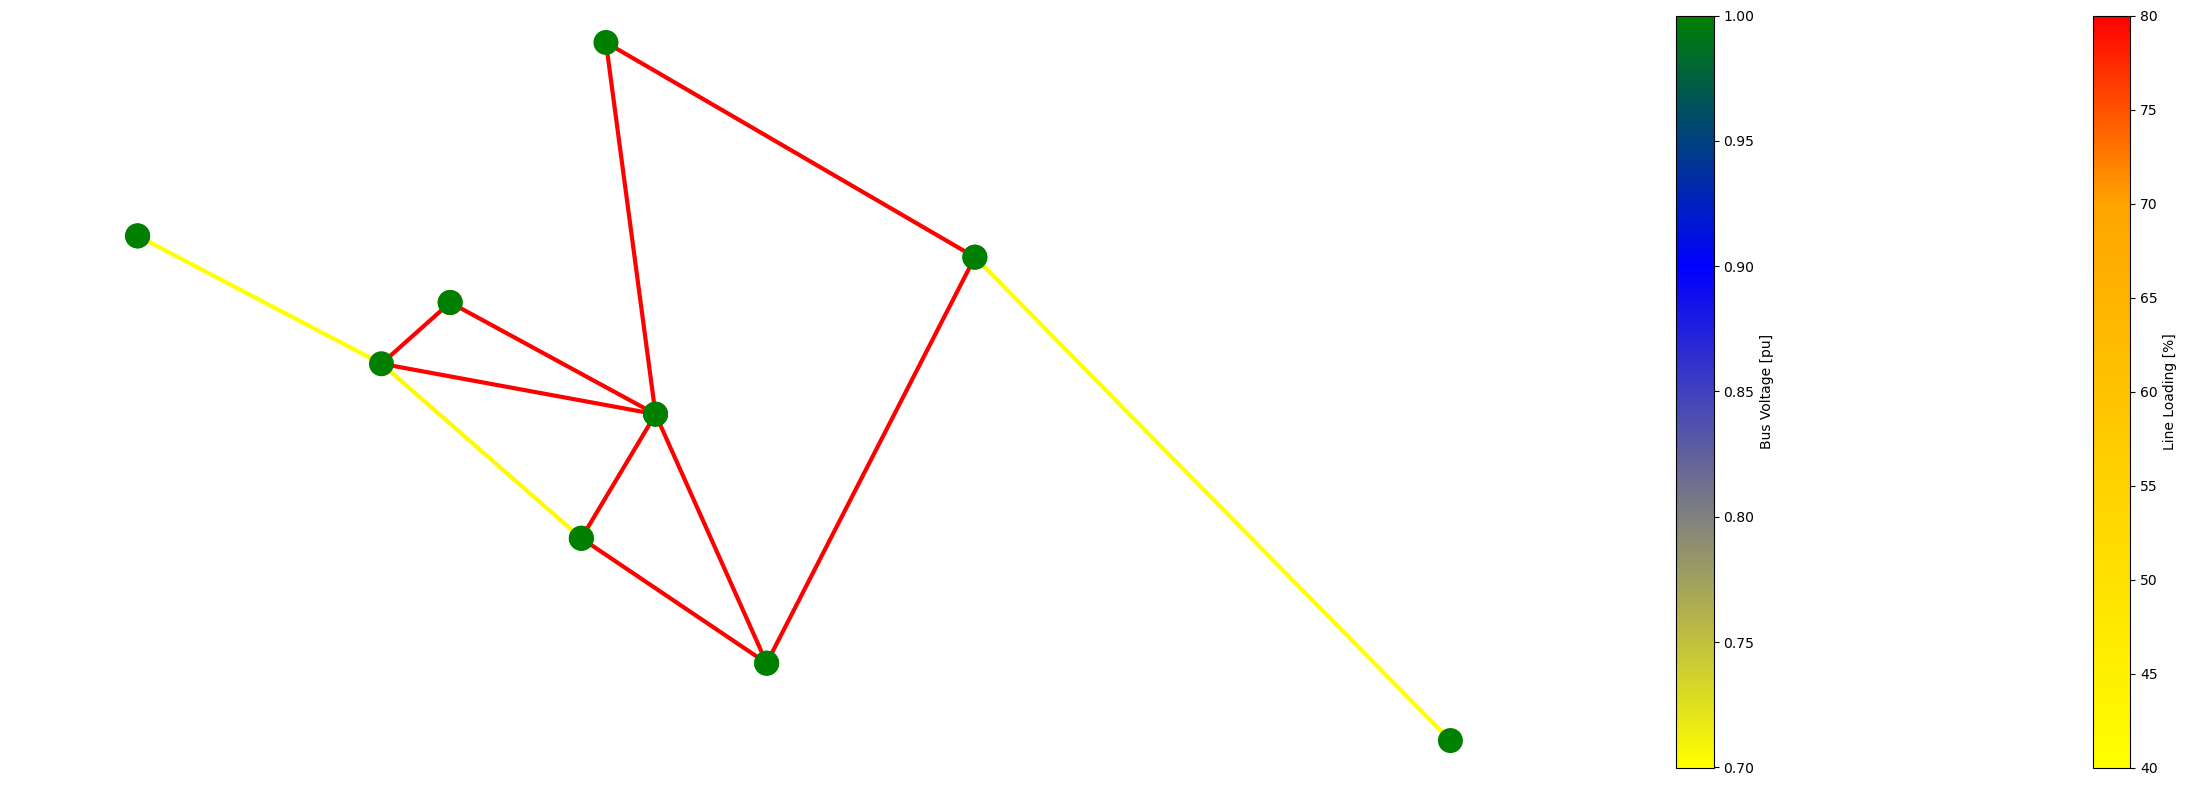

In [265]:
# Plot an advanced visual of the network showing the line loading results and voltage drops

import pandapower.plotting as plot
import matplotlib.pyplot as plt
import seaborn

# Creating the line color collection
cmap_list=[(40, "yellow"), (70, "orange"), (80, "red")]
cmap, norm = plot.cmap_continuous(cmap_list)
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=3)

# Creating the bus color collection
cmap_list=[(0.7, "yellow"), (0.9, "blue"), (1.0, "green")]
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap, norm=norm)

plot.draw_collections([lc, bc], figsize=(25,8))

In [ ]:
#Print results to an excel file
#pp.to_excel(net, "results.xlsx") 